In [325]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

In [326]:
start = 10
end = 100
l = end - start
n = 10000

X = np.random.rand(n) * l + start

In [ ]:
a = random.sample([-1 - 3 * np.random.rand(), 1 + 3 * np.random.rand()], 1)[0]
b = - 2 * a * (np.random.rand() * l + start)
c = np.random.rand() * l

def y_fn(x):
    return torch.sigmoid(torch.tensor(x - c)).numpy() * l # a * X**2 + b * X + c
Y = y_fn(X)
noise = np.random.randn(n) * np.std(Y) / 4
Y = Y + noise

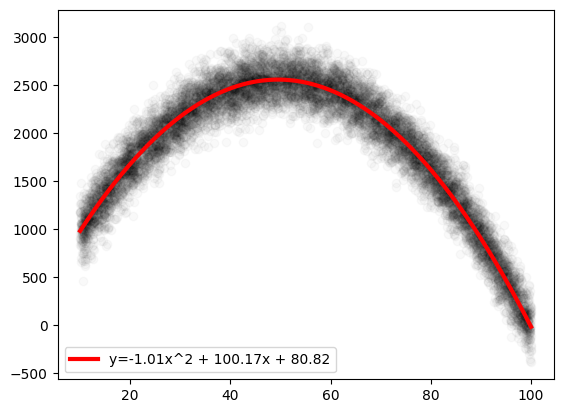

In [ ]:
f, ax = plt.subplots()
ax.scatter(X, Y, color="black", alpha=0.025)
x_clean = np.linspace(start, end, n)
y_clean = y_fn(x_clean)
ax.plot(x_clean, y_clean, color="red", lw=3, label=f"y={a:.2f}x^2 + {b:.2f}x + {c:.2f}")
ax.legend()

In [329]:
class Perceptron(nn.Module):
    def __init__(self, hidden_size, input_size=1, output_size=1):
        super().__init__()
        self.linear0_fn = nn.Linear(input_size, hidden_size)
        self.activation_fn = nn.ReLU()
        self.linear1_fn = nn.Linear(hidden_size, output_size)
         
    def forward(self, x):
        x = self.linear0_fn(x)
        x = self.activation_fn(x)
        x = self.linear1_fn(x)
        return x

In [330]:
model = Perceptron(8)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [331]:
n_epochs = 30000

In [332]:
device = torch.device("cuda")
# Normalize X inputs
X_mean = X.mean()
X_std = X.std()
X_tr = torch.tensor((X - X_mean) / X_std, device=device, dtype=torch.float32).unsqueeze(1)

# Normalize Y outputs for better training
Y_mean = Y.mean()
Y_std = Y.std()
Y_normalized = (Y - Y_mean) / Y_std
Y_tr = torch.tensor(Y_normalized, device=device, dtype=torch.float32).unsqueeze(1)

In [333]:
_ = model.to(device)

In [334]:
loss_list = []
patience = 1000  # For early stopping
best_loss = float('inf')
no_improve_count = 0

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5, min_lr=1e-6)

epochs_tqdm = tqdm.tqdm(range(n_epochs))
for i_epoch in epochs_tqdm:
    model.train()
    optimizer.zero_grad()
    out = model(X_tr)
    loss = criterion(out, Y_tr)
    loss.backward()
    optimizer.step()
    loss_item = loss.item()
    loss_list.append(loss_item)
    
    # Update learning rate scheduler
    scheduler.step(loss_item)
    
    # Early stopping logic
    if loss_item < best_loss:
        best_loss = loss_item
        no_improve_count = 0
    else:
        no_improve_count += 1
        
    if no_improve_count >= patience:
        print(f"Early stopping at epoch {i_epoch} with loss {loss_item}")
        break
        
    epochs_tqdm.set_postfix(loss=loss_item, lr=optimizer.param_groups[0]['lr'])

  9%|▉         | 2760/30000 [00:06<01:05, 418.64it/s, loss=0.0677, lr=1e-6]    

Early stopping at epoch 2760 with loss 0.06769519299268723


In [335]:
epochs_tqdm.close()

In [336]:
model.eval()
with torch.no_grad():
    idx = torch.argsort(X_tr[:, 0])
    Y_pred_normalized = model(X_tr[idx]).squeeze(1).cpu().numpy()
    # Denormalize the predictions to the original scale
    Y_pred = Y_pred_normalized * Y_std + Y_mean
    X_pred_normalized = X_tr[idx].squeeze(1).cpu().numpy()
    X_pred = X_pred_normalized * X_std + X_mean

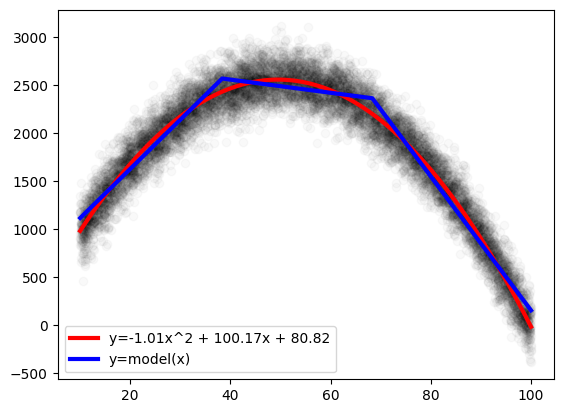

In [337]:
f, ax = plt.subplots()

ax.scatter(X, Y, color="black", alpha=0.025)

x_clean = np.linspace(start, end, n)
y_clean = a * x_clean**2 + b * x_clean + c 
ax.plot(x_clean, y_clean, color="red", lw=3, label=f"y={a:.2f}x^2 + {b:.2f}x + {c:.2f}")
ax.plot(X_pred, Y_pred, color="blue", lw=3, label=f"y=model(x)")

ax.legend()

In [338]:
model.to(torch.device("cpu"))

Perceptron(
  (linear0_fn): Linear(in_features=1, out_features=8, bias=True)
  (activation_fn): ReLU()
  (linear1_fn): Linear(in_features=8, out_features=1, bias=True)
)

In [339]:
print(model.linear0_fn.weight)
print(model.linear0_fn.bias)
print(model.linear1_fn.weight)
print(model.linear1_fn.bias)

Parameter containing:
tensor([[ 0.1194],
        [-0.5392],
        [-1.6680],
        [ 1.8046],
        [-0.1536],
        [-0.0730],
        [-0.5798],
        [-0.5292]], requires_grad=True)
Parameter containing:
tensor([-0.5430, -0.9795,  0.8501,  1.1462, -0.2976,  1.9232, -1.1753,  1.7777],
       requires_grad=True)
Parameter containing:
tensor([[-0.1346,  0.3501, -1.4166, -1.2100,  0.0253,  1.0032, -0.0197,  0.6847]],
       requires_grad=True)
Parameter containing:
tensor([0.3353], requires_grad=True)
